In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from scene_synthesis.datasets.nuScenes import NuScenesDataset
from scene_synthesis.datasets.utils import collate_train
from scene_synthesis.networks.feature_extractors import ResNet18
from scene_synthesis.networks.autoregressive_transformer import AutoregressiveTransformer

def to_numpy(data: dict):
    for k in data:
        if isinstance(data[k], torch.Tensor):
            data[k] = data[k].squeeze()
            if not data[k].shape:
                data[k] = data[k].item()
            else:
                data[k] = data[k].numpy()
        elif isinstance(data[k], dict):
            to_numpy(data[k])


In [48]:
plt.ion()
# np.random.seed(0)
# torch.manual_seed(0)
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuScene-processed", train=True)
axes_limit = 40
cat2color = {1: 'red', 2: 'blue', 3: 'green'}
feature_extractor = ResNet18(4, 512)
model = AutoregressiveTransformer(feature_extractor)
model.load_state_dict(torch.load('./ckpts/softplus'))


<All keys matched successfully>

In [53]:
data = dataset[0]
input_data, length, _ = collate_train([data])
for k in data:
    data[k] = input_data[k].squeeze(0).numpy()


In [31]:
condition = {
    "category": 3,  # int
    "location": None,  # (1, 2)
    "bbox": None,  # (1, 2), (1, 1)
    "velocity": None  # (1, 1), (1, 1), (1, 1)
}

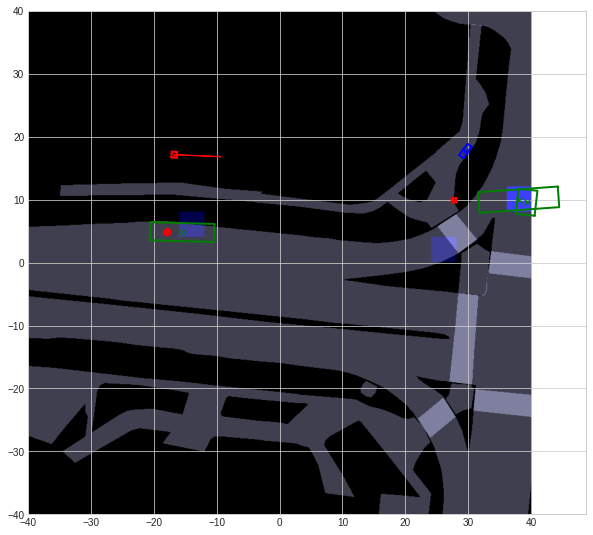

In [54]:
preds, probs = model.generate(input_data, length, condition)
to_numpy(preds)
category = preds['category']
if category != 0:
    preds['location'] = np.array([preds['location'] // 20, preds['location'] % 20]) * 4 - 40 + 2
    data['category'] = np.concatenate([data['category'], np.array([preds['category']])], axis=0)
    data['location'] = np.concatenate([data['location'], preds['location'].reshape(1, -1)], axis=0)
    data['bbox'] = np.concatenate([data['bbox'], np.concatenate([preds['wl'], np.array([preds['theta']])], axis=0).reshape(1, -1)], axis=0)
    data['velocity'] = np.concatenate([data['velocity'], np.array([[preds['s'] * preds['moving'], preds['omega']]])], axis=0)
    idx = list(range(len(data['category'])))
    idx.sort(key=lambda x: (-data['location'][x][1], data['location'][x][0]))
    for k in ['category', 'location', 'bbox', 'velocity']:
        data[k] = data[k][idx]
    input_data['category'] = torch.tensor(data['category'])
    for k in ['location', 'bbox', 'velocity', 'map']:
        input_data[k] = torch.tensor(data[k], dtype=torch.float)
    input_data, length, _ = collate_train([input_data], keep_all=True)

_, ax = plt.subplots(figsize=(10, 10))
map_layers = data['map'].sum(axis=0)
map_layers /= map_layers.max() * 2
map_layers = np.stack([map_layers] * 3, axis=-1)
grid = np.meshgrid(np.arange(-axes_limit, axes_limit, 4), np.flip(np.arange(-axes_limit, axes_limit, 4)))
grid = np.stack(grid, axis=-1)
grid = (grid + 40) // 4
grid = grid[..., 0] * 20 + grid[..., 1]
prob_map = np.exp(probs['location'].log_prob(torch.tensor(grid)).numpy())
prob_map = np.kron(prob_map, np.ones((40, 40)))
map_layers[..., 2] += prob_map
map_layers[..., 2] /= map_layers[..., 2].max()
ax.imshow(map_layers, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])
for i in range(length.item()):
    if data['category'][i] != 0:
        color = cat2color[data['category'][i]]
        loc = data['location'][i]
        ax.plot(loc[0], loc[1], 'x', color=color)
        w, l, theta = data['bbox'][i]
        corners = np.array([[l / 2, w / 2],
                            [-l / 2, w / 2],
                            [-l / 2, -w / 2],
                            [l / 2, -w / 2],
                            [l / 2, w / 2]])
        rotation = np.array([[np.cos(theta), np.sin(theta)],
                             [-np.sin(theta), np.cos(theta)]])
        corners = np.dot(corners, rotation) + loc
        ax.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
        speed, omega = data['velocity'][i]
        rotation = np.array([[np.cos(omega), np.sin(omega)],
                             [-np.sin(omega), np.cos(omega)]])
        velocity = np.dot(np.array([speed, 0]), rotation)
        ax.arrow(loc[0], loc[1], velocity[0] * 5, velocity[1] * 5, color=color, width=0.05)


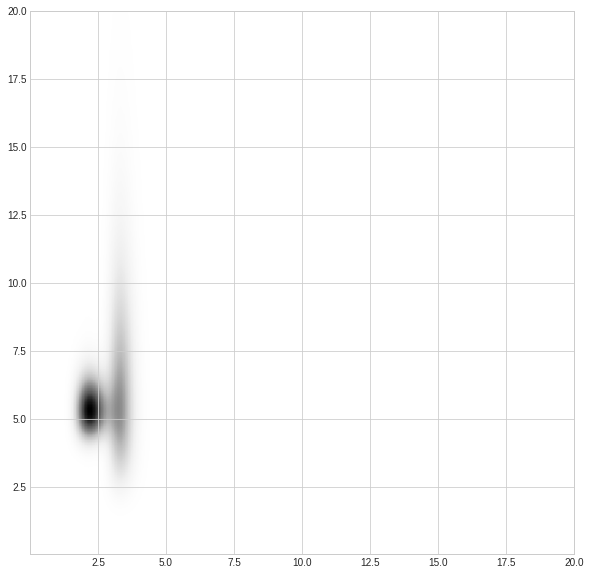

In [55]:
grid = np.meshgrid(np.linspace(0.01, 20, 200), np.linspace(20, 0.01, 200))
grid = np.stack(grid, axis=-1)
prob_map = np.exp(probs['wl'].log_prob(torch.tensor(grid)).numpy())
plt.figure(figsize=(10, 10))
plt.imshow(prob_map, extent=[0.01, 20, 0.01, 20])

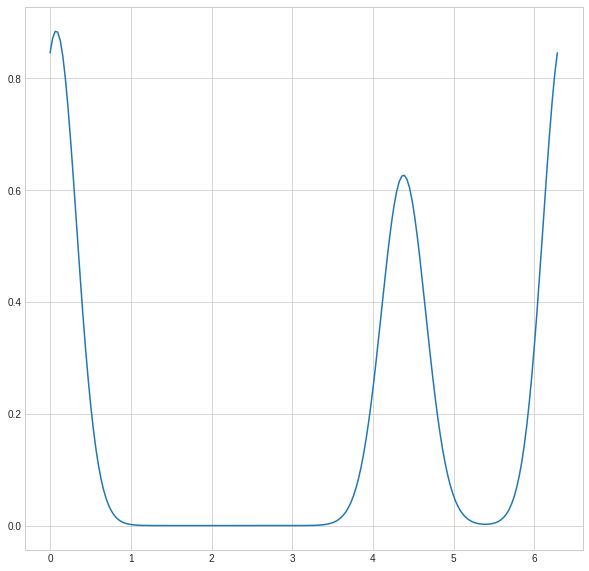

In [56]:
grid = np.linspace(0, 2 * np.pi, 200)[..., None]
prob_map = np.exp(probs['theta'].log_prob(torch.tensor(grid)).numpy())
plt.figure(figsize=(10, 10))
plt.plot(grid, prob_map)

In [20]:
probs['theta'].mixture_distribution.logits

tensor([[-3.3950, -4.2953, -0.5874, -4.4685, -6.4362, -4.9079, -3.2512, -1.2871,
         -2.8043, -6.7075]])

In [10]:
probs['theta'].component_distribution.variance

tensor([[[0.2410],
         [0.2373],
         [0.0314],
         [0.0748],
         [0.2832],
         [0.2287],
         [0.2429],
         [0.0376],
         [0.1975],
         [0.2743]]])

In [1]:
import torch
from torch.distributions import VonMises
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import numpy as np

class Test(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Parameter(torch.randn(1))
        self.concentration = nn.Parameter(torch.randn(1))
    def forward(self):
        prob = VonMises(self.loc, torch.exp(self.concentration) * 0.5)
        return -prob.log_prob(torch.tensor([1.57]))

test = Test()
optimizer = Adam(test.parameters(), lr=1e-3)

In [8]:
for i in range(2000):
    optimizer.zero_grad()
    loss = test()
    print(f'{i}: {loss.item()}')
    loss.backward()
    optimizer.step()

0: 0.4135082960128784
1: 0.4129042625427246
2: 0.41230058670043945
3: 0.4116969108581543
4: 0.4110938310623169
5: 0.4104907512664795
6: 0.40988802909851074
7: 0.40928542613983154
8: 0.4086834192276001
9: 0.4080812931060791
10: 0.40747952461242676
11: 0.4068782329559326
12: 0.406277060508728
13: 0.405676007270813
14: 0.40507543087005615
15: 0.4044748544692993
16: 0.40387463569641113
17: 0.4032747745513916
18: 0.40267515182495117
19: 0.4020756483078003
20: 0.4014763832092285
21: 0.4008774757385254
22: 0.4002789258956909
23: 0.39968013763427734
24: 0.3990819454193115
25: 0.3984839916229248
26: 0.39788639545440674
27: 0.39728879928588867
28: 0.39669179916381836
29: 0.3960946798324585
30: 0.3954979181289673
31: 0.3949016332626343
32: 0.3943052291870117
33: 0.39370906352996826
34: 0.39311349391937256
35: 0.39251768589019775
36: 0.3919224739074707
37: 0.3913273811340332
38: 0.39073264598846436
39: 0.3901381492614746
40: 0.3895437717437744
41: 0.3889498710632324
42: 0.38835597038269043
43: 0.3

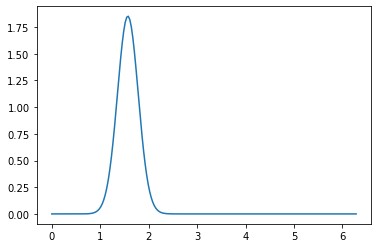

In [9]:
prob = VonMises(test.loc, torch.exp(test.concentration) * 0.5)
grid = np.linspace(0, 2 * np.pi, 200)[..., None]
prob_map = np.exp(prob.log_prob(torch.tensor(grid)).detach().numpy())
plt.plot(grid, prob_map)
plt.show()

In [10]:
test.concentration

Parameter containing:
tensor([3.7767], requires_grad=True)

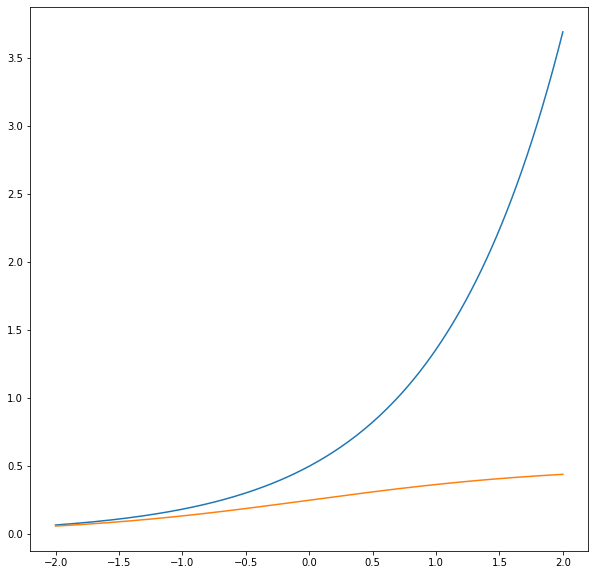

In [44]:
x = torch.linspace(-2, 2, 200)
y1 = torch.exp(x) * 0.5
y2 = torch.sigmoid(x) * 0.5
plt.figure(figsize=(10, 10))
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()